# LIGO Project
## PyCBC GW Match

In [27]:
# Filter the LIGO .gwf data file using the pyCBC software package
# Based on Alex Nitz's sample code
# Some lines added by Hao Liu to parameterize the program and for outputs

directory = 'Data/' # directory where the data files are located
suffix = '_LOSC_4_V2-1126259446-32' # suffix of the file name, not including ".gwf"
match_low_frequency_cutoff = 43. # low frequency cutoff for matching, normally chosen to be same as highpass_freq
highpass_freq = 15 # frequency for the initial high pass (Hz)
window_edge = 4
snr_edge_cut = 8 # length of edge-cut at both ends for max-SNR determination. 2016
psd_segment_length = 4 # segment length for calculating the PSD by Welch's averaging 4
f1 = match_low_frequency_cutoff
f2 = 300.

from pycbc_analysis import *

#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [28]:
data = read_strain(directory,suffix,window_edge, print_info=True)
data = estimate_psd(data,psd_segment_length, psd_window='blackman')
data = matched_filtering(data, print_info=True)

t = data['H']['TPL'].sample_times

 
****************************************************
H-file is: Data/H-H1_LOSC_4_V2-1126259446-32.gwf
H-file is from 1126259446 to 1126259478, duration: 32
 
****************************************************
L-file is: Data/L-L1_LOSC_4_V2-1126259446-32.gwf
L-file is from 1126259446 to 1126259478, duration: 32
 
****************************************************
H: Consider SNR only from 1126259446 to 1126259478, duration: 32.0
H-SNR: 18.61554935418688
H-time: 1126259446.541259766
H-phase: -2.8225527010438656
 
****************************************************
Bandpassing H-data from 43 Hz to 300 Hz.
 
****************************************************
L: Consider SNR only from 1126259446 to 1126259478, duration: 32.0
L-SNR: 13.339675893140926
L-time: 1126259446.534179688
L-phase: 0.5307061716488366
 
****************************************************
Bandpassing L-data from 43 Hz to 300 Hz.
Network SNR: 22.901651265623023


## RW CC analysis

In [29]:
# Define functions

def rw_cor(time, signal, template, sr=4096, dt=0.21, step=0.01):
    """Calculates the running-window cross correlation between signal and
    template with window size dt and step size step."""
    
    # Initialize arrays and vals
    
    #time = np.round(time,30)
    t_i = time[0]-time[0]
    t_f = time[len(time)-1]-time[0]
    
    t1 = np.array([])
    t2 = np.array([])
    t = np.array([])
    i_sta = np.array([])
    i_sto = np.array([])
    cc = np.array([])
    
    t_1 = t_i
    t_2 = t_i + dt
    
    while t_i < t_f:
        
        # Slices signal and template into interval between t_1 and t_2
        # Convert slices to mpf.
        #indeces = np.where(np.logical_and(time>=t_1, time<=t_2))
        i_start = int(np.round(t_1*sr)) #int(indeces[0][0])
        i_stop = int(np.round(t_2*sr))+1 #int(indeces[0][-1])+1
        sgnl_int = signal[i_start:i_stop]
        tmpl_int = template[i_start:i_stop]
        
        # Calculate window position and cross correlation of signal and
        # template intervals.
        mid_time = (t_2+t_1)/2
        sgnl_int = sgnl_int-np.mean(sgnl_int)
        tmpl_int = tmpl_int-np.mean(tmpl_int)
        num = np.sum(sgnl_int*tmpl_int)
        den = np.sqrt(np.sum(sgnl_int**2)*np.sum(tmpl_int**2))
        if den == 0:
            cor = 0
        else:
            cor = num/den
            #cor = np.sum(sgnl_int*tmpl_int)/np.sqrt(np.sum(np.square(sgnl_int))\
                         #*np.sum(np.square(tmpl_int)))
        
        # Append values to defined arrays, repeat loop.
        t = np.append(t,mid_time)
        t1 = np.append(t1,t_1)
        t2 = np.append(t2,t_2)
        i_sta = np.append(i_sta, i_start)
        i_sto = np.append(i_sto, i_stop)
        cc = np.append(cc, cor)
        t_1 += step
        t_2 += step
        t_i = t_2
    
    return cc, t#, t1, t2, i_sta, i_sto

def running_avg(x, n):
    """ Running window average using 2n+1 data points to calculate average.
    """

    ravg = np.array([])
    
    # Add n/2 padding to each side of data. Use n/2 mirrored data-points
    # around i = o and i = len(x). n must be whole number
    stop = int(n/2)+1
    
    x = np.concatenate((np.flip(x[1:stop],-1),x))
    x = np.append(x,np.flip(x[-stop:len(x)-1],-1))
    
    # Calculate running average
    size = len(x)
    for i in range(size-n+1):
            avg = np.mean(x[i:n+i])
            ravg = np.append(ravg,avg)
    return ravg

def hist(data, no_bins = 0, pdf = True, title="",lbl="", color='k'):
    if no_bins == 0:
        no_bins = round(len(data)/3)
        print("No. of bins in '"+ title+"':")
        print(no_bins)
    values, bins = np.histogram(data, no_bins, density = pdf)
    center = (bins[:-1]+bins[1:])/2
    plt.plot(center,values,label=lbl,c=color)
    plt.title(title)
    if pdf == True:
        plt.ylabel("PDF")

def kullback_leibler(dist, model):
    vals = []
    dist = dist/np.sum(dist)
    model = model/np.sum(model)
    for i,j in zip(dist, model):
        if i == 0:
            val_tmp = 0
        else:
            val_tmp = i*np.log(i/j)
        vals.append(val_tmp)
    theta = np.sum(vals)
    return theta

In [30]:
# Running window CC analysis
# PyCBC

CCH_PYCBC_M, pos_PYCBC_M = rw_cor(t, data['H']['TPL']._data, data['H']['R']._data)
CCL_PYCBC_M, pos_PYCBC_M = rw_cor(t, data['L']['TPL']._data, data['L']['R']._data)
CCH_PYCBC_M = running_avg(CCH_PYCBC_M, 51)
CCL_PYCBC_M = running_avg(CCL_PYCBC_M, 51)

<IPython.core.display.Javascript object>


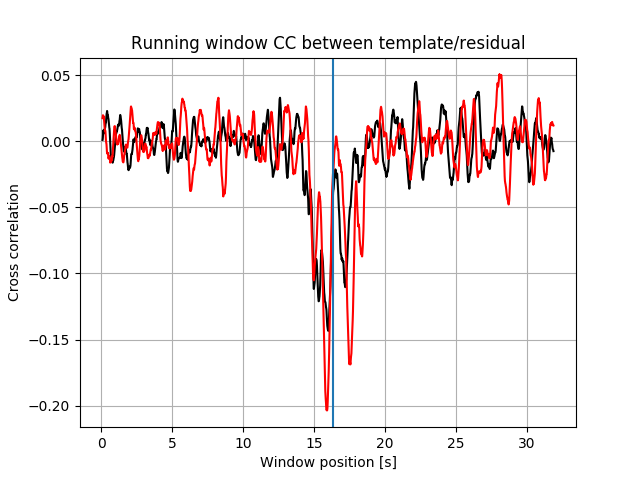

Text(0.5,1,'Running window CC between template/residual')

In [31]:
# Plot running window CC analysis
#plt.close('all')
plt.figure(1)
plt.plot(pos_PYCBC_M, CCH_PYCBC_M, c='k', label='Hanford')
plt.plot(pos_PYCBC_M, CCL_PYCBC_M, c='r', label='Livingston')
plt.axvline(16.36)
plt.xlabel('Window position [s]')
plt.ylabel('Cross correlation')
plt.grid('True')
plt.title('Running window CC between template/residual')

# Frequency analysis

 
****************************************************
H-file is: Data/H-H1_LOSC_4_V2-1126259446-32.gwf
H-file is from 1126259446 to 1126259478, duration: 32
 
****************************************************
L-file is: Data/L-L1_LOSC_4_V2-1126259446-32.gwf
L-file is from 1126259446 to 1126259478, duration: 32


<IPython.core.display.Javascript object>


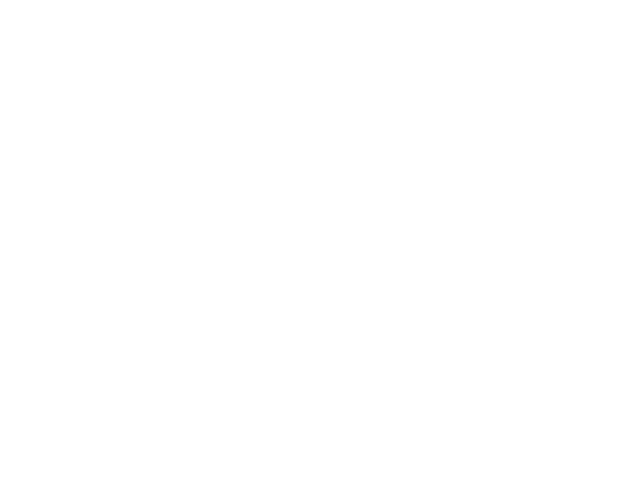

<IPython.core.display.Javascript object>


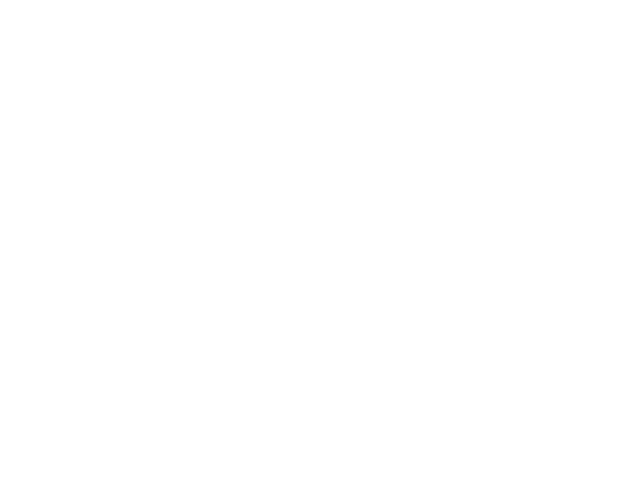

<IPython.core.display.Javascript object>


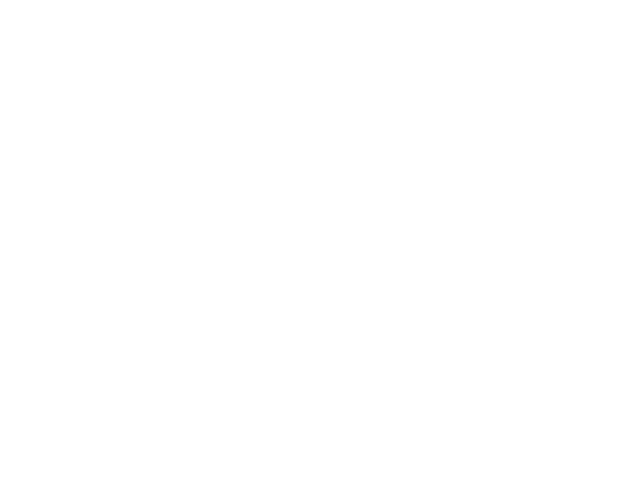

<IPython.core.display.Javascript object>


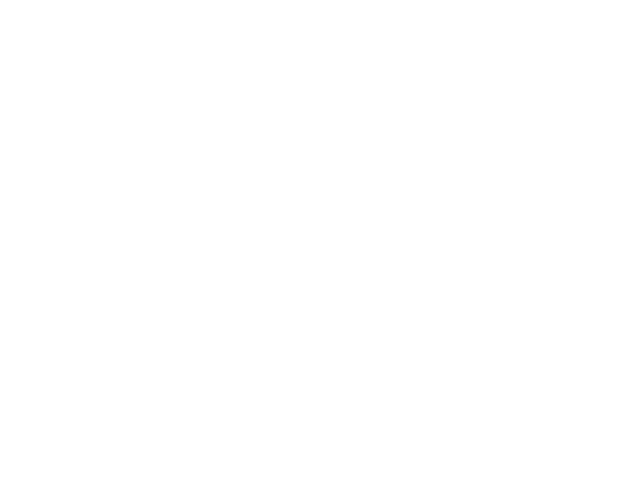

<IPython.core.display.Javascript object>


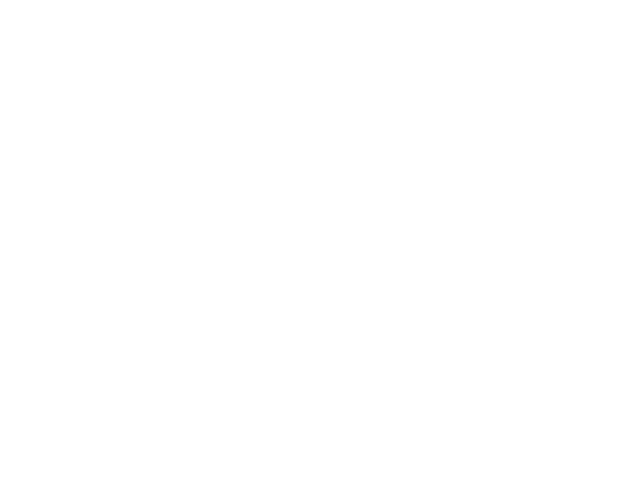

<IPython.core.display.Javascript object>


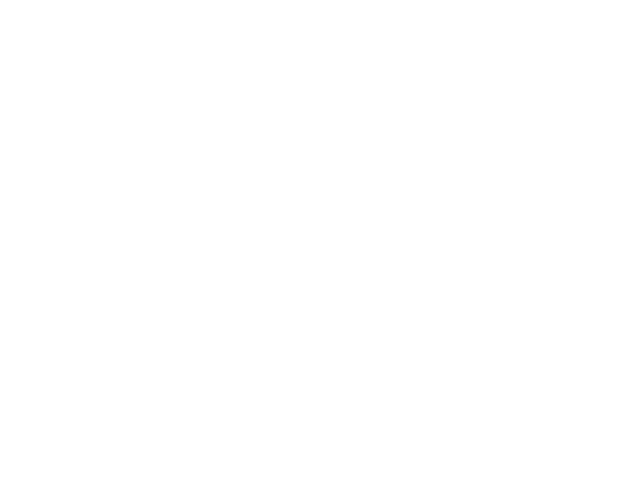

<IPython.core.display.Javascript object>


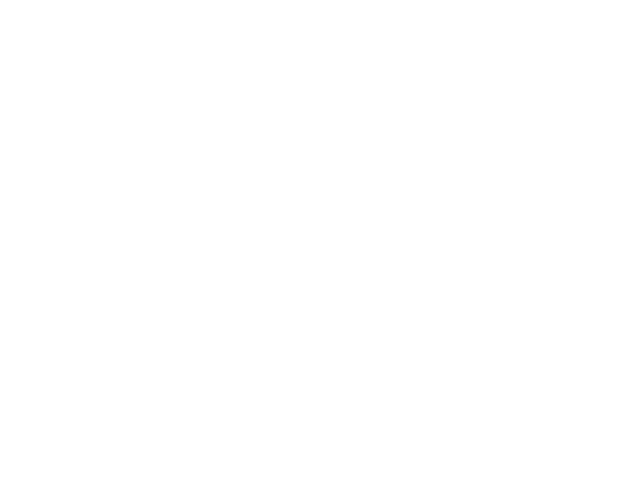

<IPython.core.display.Javascript object>


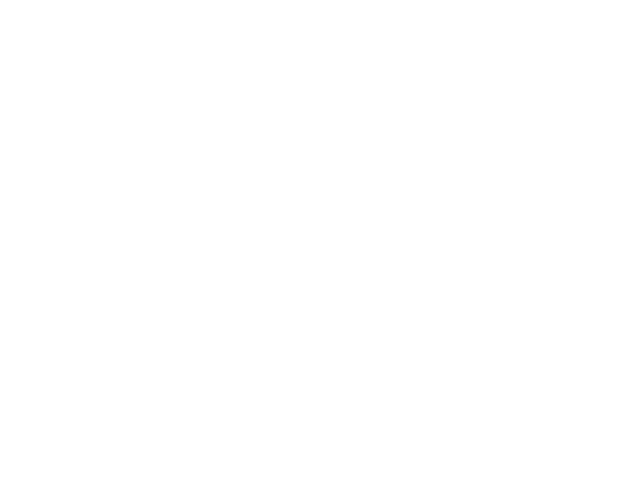

<IPython.core.display.Javascript object>


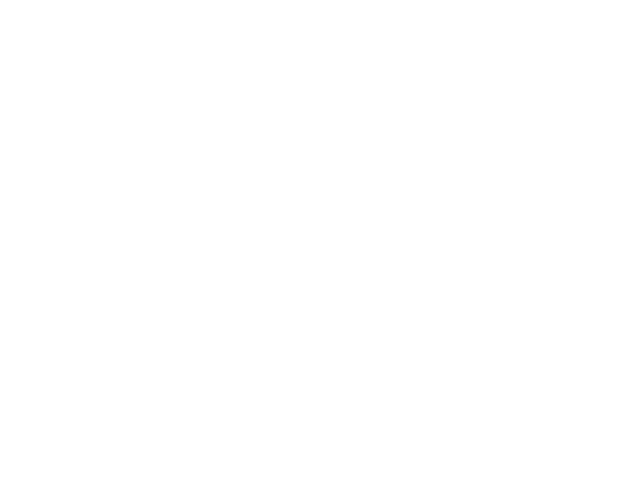

<IPython.core.display.Javascript object>


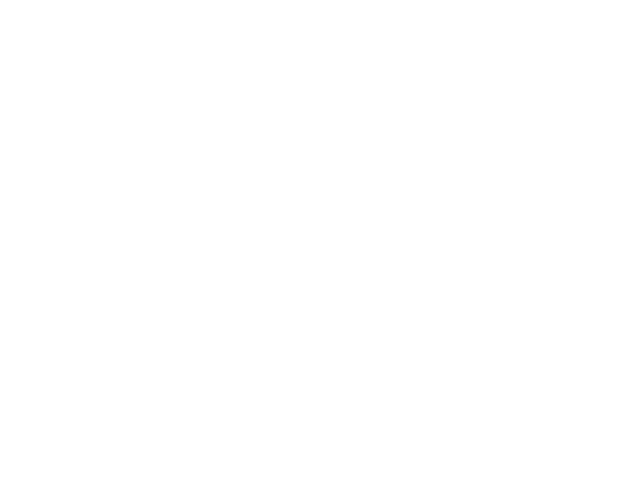

<IPython.core.display.Javascript object>


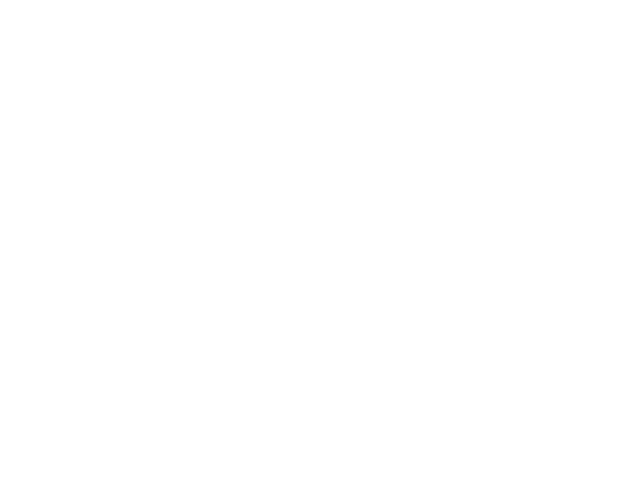

<IPython.core.display.Javascript object>


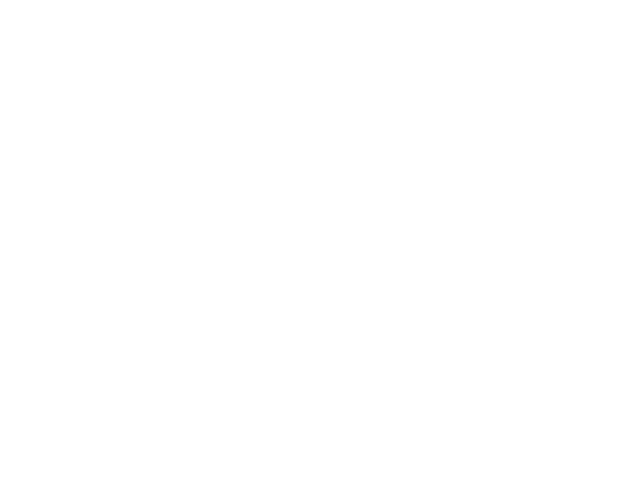

<IPython.core.display.Javascript object>


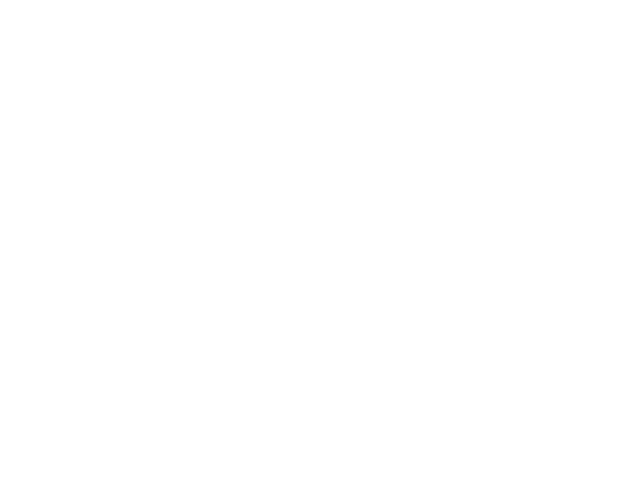

<IPython.core.display.Javascript object>


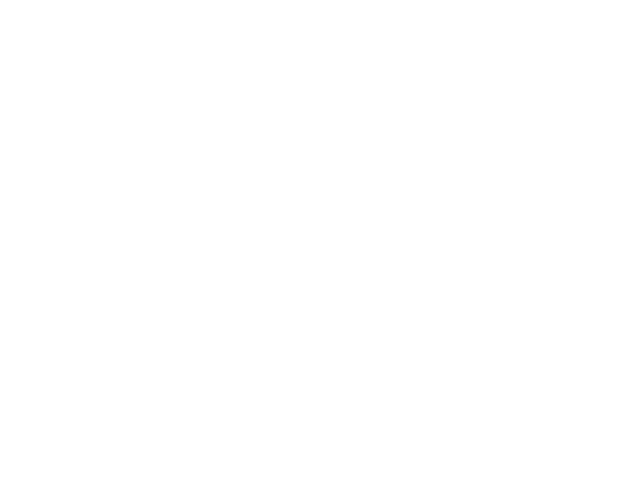

<IPython.core.display.Javascript object>


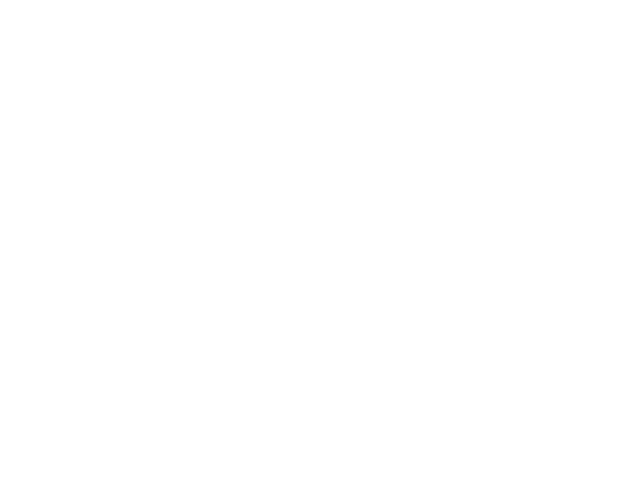

<IPython.core.display.Javascript object>


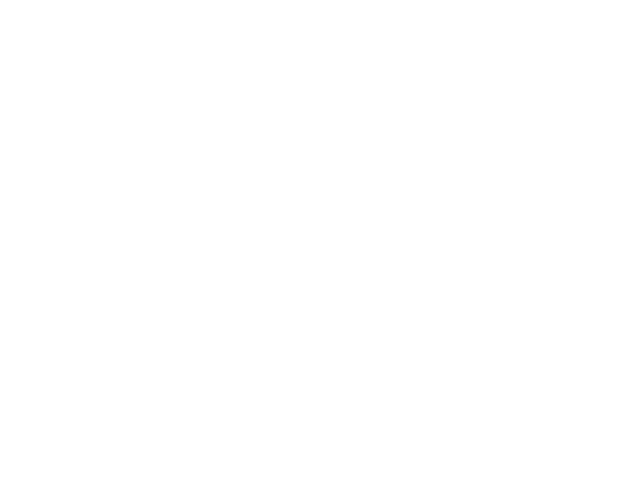

<IPython.core.display.Javascript object>


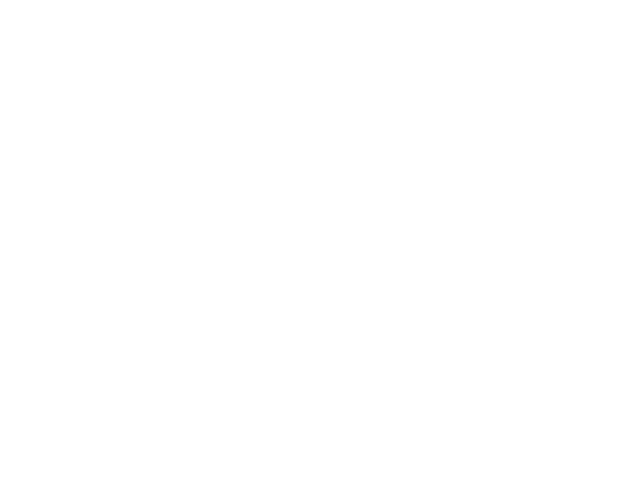

<IPython.core.display.Javascript object>


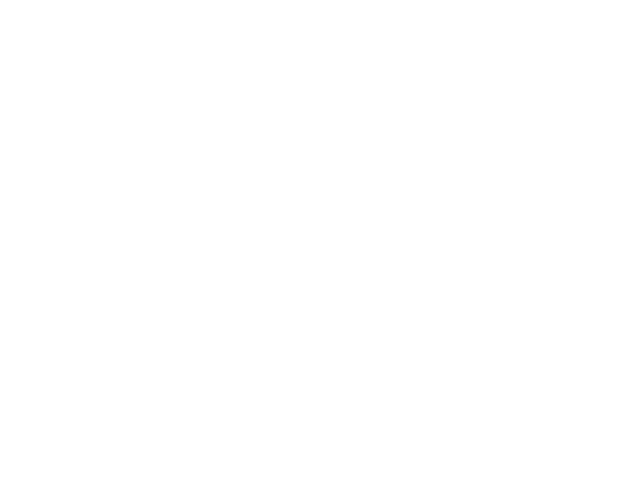

<IPython.core.display.Javascript object>


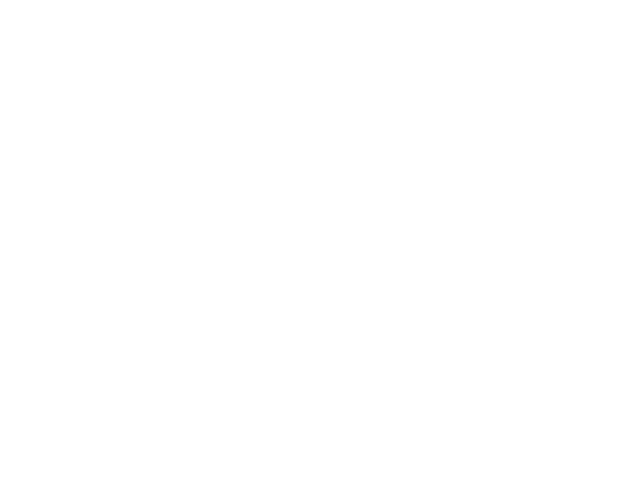

<IPython.core.display.Javascript object>


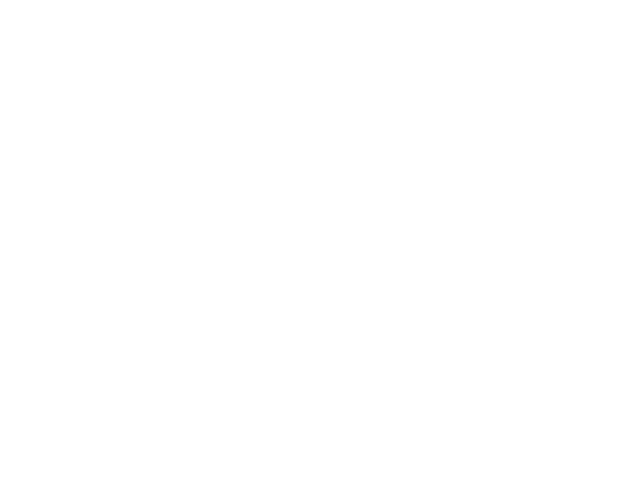

<IPython.core.display.Javascript object>


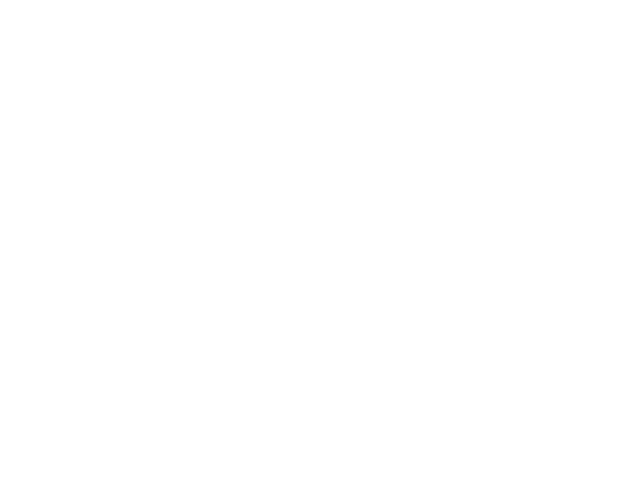

<IPython.core.display.Javascript object>


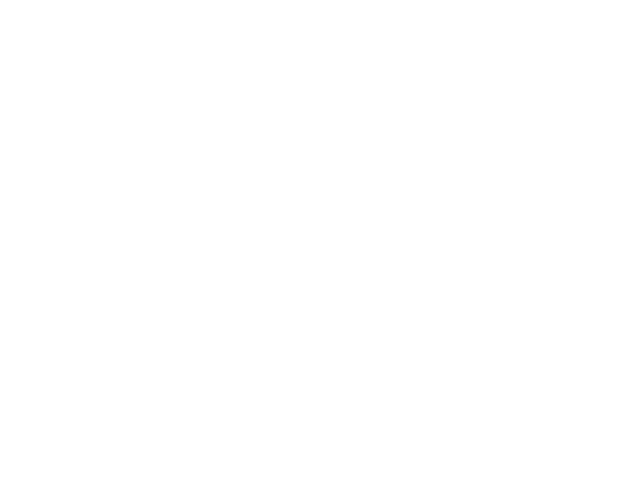

<IPython.core.display.Javascript object>


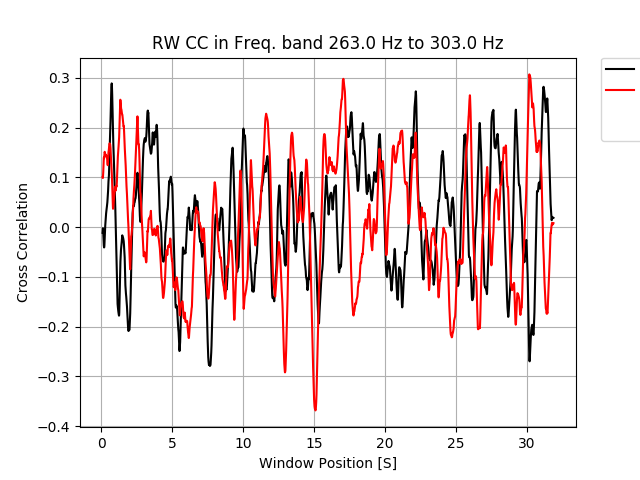

In [33]:
data = read_strain(directory,suffix,window_edge, print_info=True)
data = estimate_psd(data,psd_segment_length, psd_window='blackman')

plot = True
f1 = 43.
f2 = 300.
df = 40
f_step = 10.
n = int(np.ceil((f2-f1-df)/f_step))+1

min_bf = np.zeros(n)
min_af = np.zeros(n)

min_bf_normed = np.zeros(n)
min_af_normed = np.zeros(n)

freqs = np.zeros((2,n))

for i in range(n):
    
    bpf1 = f1+i*f_step
    bpf2 = f1+df+i*f_step
    
    freqs[:,i] = [bpf1,bpf2]
    
    data = matched_filtering(data, bpf1=bpf1, bpf2=bpf2)
    
    CCH, pos = rw_cor(t, data['H']['TPL']._data, data['H']['R']._data)
    CCL, pos = rw_cor(t, data['L']['TPL']._data, data['L']['R']._data)
    CCH = running_avg(CCH, 51)
    CCL = running_avg(CCL, 51)
        
    index1 = np.logical_and(pos > 14.00, pos<16.36)
    index2 = np.logical_and(pos > 16.36, pos<18.00)
    
    CCH_bf = CCH[index1].min()#/np.max(np.abs(CCH))
    CCL_bf = CCL[index1].min()#/np.max(np.abs(CCL))
    CCH_af = CCH[index2].min()#/np.max(np.abs(CCH))
    CCL_af = CCL[index2].min()#/np.max(np.abs(CCL))
    
    CCH_bf_normed = CCH_bf/np.max(np.abs(CCH))
    CCL_bf_normed = CCL_bf/np.max(np.abs(CCL))
    CCH_af_normed = CCH_af/np.max(np.abs(CCH))
    CCL_af_normed = CCL_af/np.max(np.abs(CCL))
    
    min_bf[i] = CCH_bf*CCL_bf/(CCH_bf+CCL_bf)
    min_af[i] = CCH_af*CCL_af/(CCH_af+CCL_af)
    min_bf_normed[i] = CCH_bf_normed*CCL_bf_normed/(CCH_bf_normed+CCL_bf_normed)
    min_af_normed[i] = CCH_af_normed*CCL_af_normed/(CCH_af+CCL_af_normed)
    
    if plot:
        plt.close('all')
        fig, ax = plt.subplots()
        ax.plot(pos, CCH, label='Hanford', c='k')
        ax.plot(pos, CCL, label='Livingston', c='r')
        ax.grid('True')
        ax.set_xlabel('Window Position [S]')
        ax.set_ylabel('Cross Correlation')

        min_bf_normed = np.round(min_bf_normed,2)
        min_af_normed = np.round(min_af_normed,2)
        
        string = 'Relative CC before event: %s \nRelative CC after event: %s' %(min_bf_normed[i], min_af_normed[i])
        handles, labels = ax.get_legend_handles_labels()
        handles.append(mpatches.Patch(color='none', label=string))
        lgd = ax.legend(handles=handles,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax.set_title('RW CC in Freq. band %s Hz to %s Hz' %(bpf1,bpf2))
        plt.savefig('Plots/Spectral analysis/%s_%s.pdf' %(bpf1,bpf2),bbox_extra_artists=(lgd,), bbox_inches='tight')